<a href="https://colab.research.google.com/github/Ash100/DiSHaN/blob/main/ESM2_Snake_Venome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch transformers sentencepiece

In [ ]:
# 1. INSTALLATION
!pip install git+https://github.com/facebookresearch/esm.git
!pip install biopython scikit-learn matplotlib seaborn

In [8]:
import torch
import esm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Libraries installed and imported.")


Libraries installed and imported.


In [42]:
# --- CONFIGURATION ---
FASTA_FILE = "/content/PEPS.fas"  # Ensure your file is uploaded to the Colab 'Files' tab
CONTROLS = [
    "Zinc metalloproteinase/disintegrin-1", "Zinc metalloproteinase/disintegrin-2", "Zinc metalloproteinase/disintegrin-3, ""Disintegrin obtustatin",
    "L-aminoacid oxidase", "Basic phospholipase A2 F17",
    "Zinc metalloproteinase-disintegrin-like VAP2A", "Thrombin-like enzyme collinein-1",
    "Kunitz-type serine protease inhibitor PIVL", "Cytotoxin 3",
    "Acidic phospholipase A2 2", "L-aminoacid oxidase", "Zinc metalloproteinase-disintegrin BlatH1",
    "Alpha-fibrinogenase", "Snake venom 5'-nucleotidase"
]

def load_and_clean_fasta(path):
    sequences = []
    # Regex to keep only valid uppercase Amino Acid letters
    aa_regex = re.compile(r'[^ACDEFGHIKLMNPQRSTVWY]')

    for record in SeqIO.parse(path, "fasta"):
        # Ensure uppercase and strip non-sequence text
        clean_seq = aa_regex.sub('', str(record.seq).upper())

        if clean_seq:
            is_control = any(ctrl.lower() in record.description.lower() for ctrl in CONTROLS)
            sequences.append({
                "id": record.description[:50],
                "sequence": clean_seq,
                "type": "Control" if is_control else "Target"
            })
    return sequences

processed_data = load_and_clean_fasta(FASTA_FILE)
print(f"Loaded {len(processed_data)} valid sequences.")

Loaded 110 valid sequences.


In [43]:
# Load ESM-2 Model (650M parameters)
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    print("GPU found! Processing with acceleration.")

embeddings_list = []
for item in processed_data:
    labels, strs, tokens = batch_converter([(item["id"], item["sequence"])])
    if torch.cuda.is_available():
        tokens = tokens.cuda()

    with torch.no_grad():
        results = model(tokens, repr_layers=[33])
        reps = results["representations"][33]

        # Mean pooling: Average across the length of the sequence
        seq_len = len(item["sequence"])
        mean_emb = reps[0, 1 : seq_len + 1].mean(0).cpu().numpy()
        embeddings_list.append(mean_emb)

vectors = np.array(embeddings_list)
print(f"Embeddings generated. Matrix shape: {vectors.shape}")

GPU found! Processing with acceleration.
Embeddings generated. Matrix shape: (110, 1280)


In [44]:
# Standardize and run PCA
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(vectors)

pca = PCA(n_components=2)
coords = pca.fit_transform(scaled_vectors)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(coords, columns=['PC1', 'PC2'])
df_plot['Type'] = [item['type'] for item in processed_data]
df_plot['ID'] = [item['id'] for item in processed_data]

print(f"PCA complete. Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

PCA complete. Variance explained: 30.9%


In [ ]:
!pip install adjustText

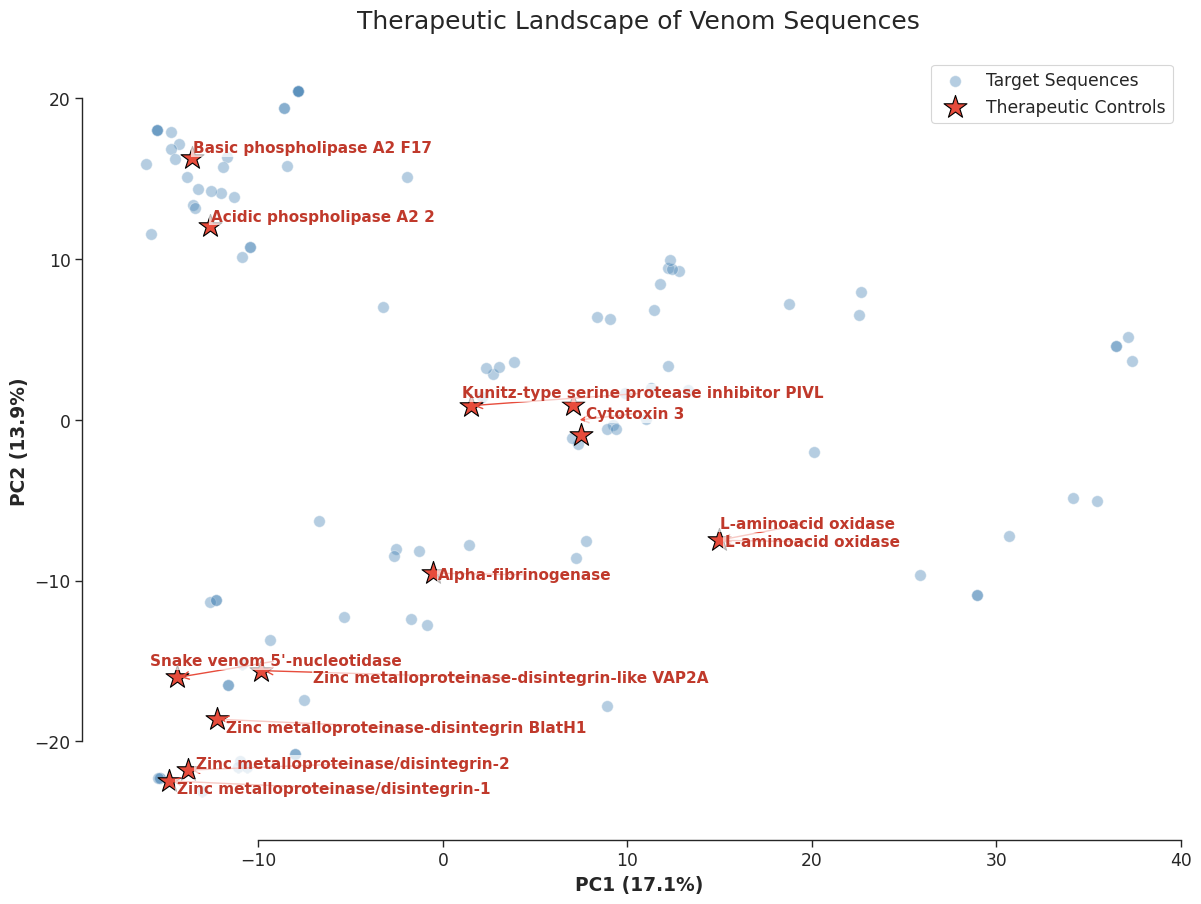

In [45]:
from adjustText import adjust_text

# Set Aesthetic Style
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

fig, ax = plt.subplots(figsize=(14, 10))

# 1. Plot Targets (Steel Blue)
sns.scatterplot(
    data=df_plot[df_plot['Type'] == 'Target'],
    x='PC1', y='PC2', alpha=0.4, s=70,
    color='#4682B4', label='Target Sequences', edgecolor='w', zorder=1
)

# 2. Plot ALL Control Stars
sns.scatterplot(
    data=df_plot[df_plot['Type'] == 'Control'],
    x='PC1', y='PC2', s=300,
    color='#e74c3c', marker='*', label='Therapeutic Controls',
    edgecolor='black', linewidth=0.8, zorder=2
)

# 3. SMART KEYWORD LABELING (The "One Label Per Category" Fix)
texts = []
# We use the CONTROLS list you defined earlier to find the centers
for ctrl_keyword in CONTROLS:
    # Find all rows that contain this keyword in their ID
    mask = df_plot['ID'].str.contains(ctrl_keyword, case=False, na=False)
    subset = df_plot[mask]

    if not subset.empty:
        # Calculate the mathematical center (mean) of all stars in this category
        center_x = subset['PC1'].mean()
        center_y = subset['PC2'].mean()

        texts.append(plt.text(
            center_x,
            center_y,
            ctrl_keyword, # Only label the category name
            fontsize=11,
            weight='bold',
            color='#c0392b',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1), # Add slight background to read over dots
            zorder=4
        ))

# 4. Resolve Overlaps
# This will push the category labels away from each other
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1),
    expand_points=(2.0, 2.0),
    expand_text=(1.5, 1.5),
    ax=ax
)

# 5. Final Formatting
plt.title("Therapeutic Landscape of Venom Sequences", fontsize=18, pad=20)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", weight='bold')
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", weight='bold')

sns.despine(trim=True, offset=10)
ax.grid(False)

# 6. Save
plt.savefig("Venom_PCA_Categorical_Labels_600DPI.png", dpi=600, bbox_inches='tight')
plt.show()

In [46]:
# Save results to a CSV
df_plot.to_csv("esm2_clustering_results.csv", index=False)
print("Results saved to 'esm2_clustering_results.csv'. Check the folder icon on the left.")

Results saved to 'esm2_clustering_results.csv'. Check the folder icon on the left.


1. K-Means Clustering (Explicit Grouping)
We will use K-Means. It mathematically assigns every one of your 113 sequences to a specific cluster. We will then check if our "Targets" are being put into the same cluster as your "Controls."

/tmp/ipython-input-808258971.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bx-', markersize=8, linewidth=2, color='#4682B4')


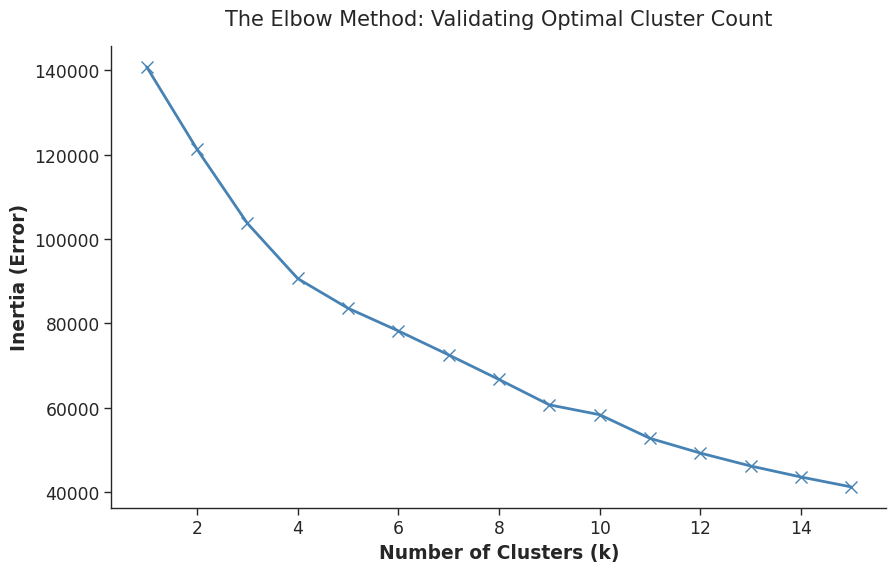

2 [-0.70955657  0.55850735]
8 [-0.88438905 -0.70405613]


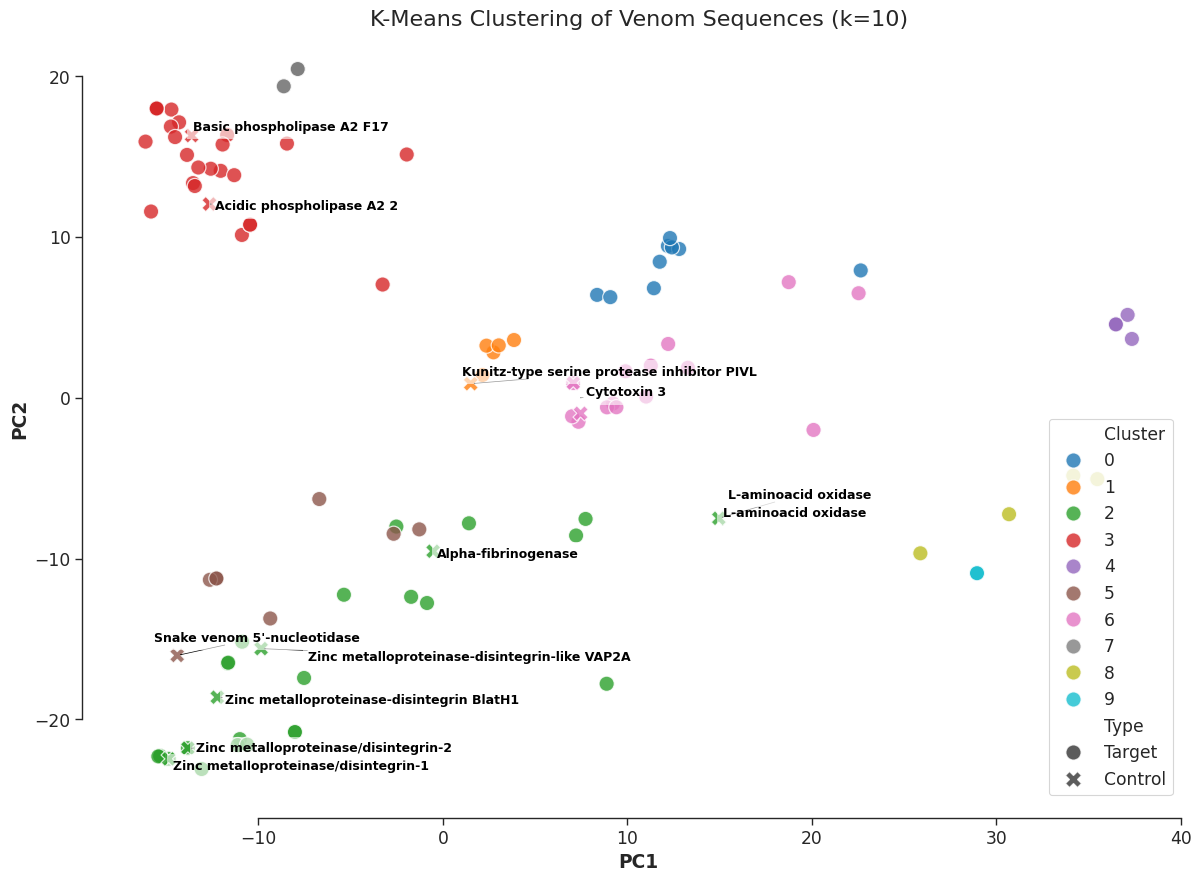


--- Cluster Composition Table ---
Type     Control  Target
Cluster                 
0              0       9
1              1       5
2              6      23
3              2      24
4              0       4
5              1       7
6              2      14
7              0       6
8              0       4
9              0       2


In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. VALIDATION: THE ELBOW METHOD ---
inertia = []
K = range(1, 16)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeanModel.fit(scaled_vectors)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-', markersize=8, linewidth=2, color='#4682B4')
plt.xlabel('Number of Clusters (k)', weight='bold')
plt.ylabel('Inertia (Error)', weight='bold')
plt.title('The Elbow Method: Validating Optimal Cluster Count', fontsize=15, pad=15)
sns.despine()
plt.grid(False)

# SAVE ELBOW PLOT (600 DPI)
plt.savefig("Venom_Elbow_Plot_Validation_600DPI.png", dpi=600, bbox_inches='tight')
plt.show()

# --- 2. APPLY K-MEANS CLUSTERING ---
# Set to 10 based on your Elbow analysis
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df_plot['Cluster'] = kmeans.fit_predict(scaled_vectors)

# --- 3. VISUALIZE CLUSTERS WITH CATEGORICAL LABELS ---
plt.figure(figsize=(14, 10))
sns.set_style("ticks")

# Plot using Cluster IDs as colors
scatter = sns.scatterplot(
    data=df_plot, x='PC1', y='PC2',
    hue='Cluster', palette='tab10', # tab10 is great for 10 distinct groups
    style='Type', s=120, alpha=0.8, edgecolor='w', zorder=1
)

# Overlay our "Keyword Centroid" labeling logic to see where categories sit
texts = []
for ctrl_keyword in CONTROLS:
    mask = df_plot['ID'].str.contains(ctrl_keyword, case=False, na=False)
    subset = df_plot[mask]
    if not subset.empty:
        center_x, center_y = subset['PC1'].mean(), subset['PC2'].mean()
        texts.append(plt.text(center_x, center_y, ctrl_keyword,
                             fontsize=9, weight='bold', color='black',
                             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')))

from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.title(f"K-Means Clustering of Venom Sequences (k={n_clusters})", fontsize=16)
plt.xlabel(f"PC1", weight='bold')
plt.ylabel(f"PC2", weight='bold')
sns.despine(trim=True, offset=10)
plt.grid(False)

# SAVE CLUSTER PLOT (600 DPI)
plt.savefig("Venom_KMeans_Clusters_600DPI.png", dpi=600, bbox_inches='tight')
plt.show()

# --- 4. EXPORT FINAL RESULTS ---
# This creates the table showing which targets share a cluster with controls
cluster_summary = df_plot.groupby(['Cluster', 'Type']).size().unstack(fill_value=0)
print("\n--- Cluster Composition Table ---")
print(cluster_summary)

# Save the full mapping to CSV
df_plot.to_csv("Final_Sequence_Cluster_Mapping.csv", index=False)

**Elbow Plot**<br> Elbow Plot, a standard diagnostic tool used to determine the optimal number of clusters ($k$) for a dataset—in our case, the 113 protein sequences.It provides a mathematical "reality check" for your PCA plot. While the PCA shows you a map, this plot tells you how many "neighborhoods" actually exist on that map.
**Key Components of the Graph:X-Axis (Number of Clusters $k$):**<br> This represents the number of groups you are asking the computer to create.<br>**Y-Axis (Inertia/Error):**<br> Technically called Within-Cluster Sum of Squares (WCSS). It measures how far away the protein sequences are from the center of their assigned cluster.<br>**High Inertia:**<br> The groups are loose and messy.<br>**Low Inertia:**<br> The groups are tight and cohesive.<br>**The Blue Line:**<br> As you increase the number of clusters, the error always goes down because the groups get smaller and tighter.<br>**How to Interpret Your Specific Result:**<br>To find the "optimal" $k$, you look for the "Elbow"—the point where the sharp drop slows down and the line starts to level off.The Sharp Drop (k=1 to k=4): Moving from 1 to 4 clusters significantly reduces error. This suggests your sequences are definitely not one giant random blob; they have distinct structural families.<br>**The Elbow Point (k=4):**<br> There is a noticeable "bend" at $k=4$. This suggests that 4 is a very strong candidate for the number of major protein families in your dataset.<br>**The Subtle Bend (k=6 to k=8):**<br> You'll notice another slight softening of the curve around 6 or 8. This often happens with venom proteins because you have broad families (like "Metalloproteinases") that contain smaller, distinct sub-types.

**We went for the 10 clusters based on the recommendation of Elbow PLot**

Now we are going to calculate the Nearest Neighbours to the Control in Cluster 1, 2, 3, 5, and 6. Because only these clusters contain the Control representation.

In [48]:
from scipy.spatial.distance import cdist

# --- 1. SET TARGET CLUSTERS ---
target_clusters = [1, 2, 3, 5, 6]

# --- 2. CALCULATE DISTANCES ---
# We use the 'vectors' array (raw ESM-2 embeddings) for maximum precision
results_list = []

for cluster_id in target_clusters:
    # Filter data for this specific cluster
    cluster_df = df_plot[df_plot['Cluster'] == cluster_id]

    # Get indices for Controls and Targets within this cluster
    ctrl_indices = cluster_df[cluster_df['Type'] == 'Control'].index
    target_indices = cluster_df[cluster_df['Type'] == 'Target'].index

    if len(ctrl_indices) > 0 and len(target_indices) > 0:
        # Calculate distance from every control to every target in this cluster
        dist_matrix = cdist(vectors[ctrl_indices], vectors[target_indices], metric='euclidean')

        for i, ctrl_idx in enumerate(ctrl_indices):
            ctrl_name = df_plot.loc[ctrl_idx, 'ID']

            # Find top 5 closest targets
            distances = dist_matrix[i]
            # Get indices of targets sorted by distance
            closest_target_sub_indices = np.argsort(distances)[:5]

            for rank, sub_idx in enumerate(closest_target_sub_indices):
                actual_target_idx = target_indices[sub_idx]
                results_list.append({
                    "Cluster": cluster_id,
                    "Reference Control": ctrl_name,
                    "Nearest Neighbor (Target)": df_plot.loc[actual_target_idx, 'ID'],
                    "Distance Score": round(distances[sub_idx], 4),
                    "Rank": rank + 1
                })

# --- 3. FORMAT AND DISPLAY ---
nn_df = pd.DataFrame(results_list)

if nn_df.empty:
    print("No matches found. Check if the specified clusters contain both Controls and Targets.")
else:
    # Display the top results
    print("--- Nearest Neighbors to Controls (Top 5 per Control) ---")
    display(nn_df)

    # --- 4. SAVE RESULTS ---
    nn_df.to_csv("Control_Nearest_Neighbors.csv", index=False)
    print("\nResults saved to 'Control_Nearest_Neighbors.csv'")

--- Nearest Neighbors to Controls (Top 5 per Control) ---


,Cluster,Reference Control,Nearest Neighbor (Target),Distance Score,Rank
0,1,Kunitz-type serine protease inhibitor PIVL,Kunitz-type serine protease inhibitor homolog ...,1.1533,1
1,1,Kunitz-type serine protease inhibitor PIVL,Kunitz-type serine protease inhibitor homolog ...,1.1636,2
2,1,Kunitz-type serine protease inhibitor PIVL,Kunitz-type serine protease inhibitor taicotoxin,1.1713,3
3,1,Kunitz-type serine protease inhibitor PIVL,Kunitz-type serine protease inhibitor homolog ...,1.1832,4
4,1,Kunitz-type serine protease inhibitor PIVL,Kunitz-type serine protease inhibitor homolog ...,1.2545,5
5,2,Zinc metalloproteinase/disintegrin-1,Zinc metalloproteinase/disintegrin,0.0000,1
6,2,Zinc metalloproteinase/disintegrin-1,Zinc metalloproteinase/disintegrin,0.5942,2
7,2,Zinc metalloproteinase/disintegrin-1,Zinc metalloproteinase/disintegrin,0.5942,3
8,2,Zinc metalloproteinase/disintegrin-1,Zinc metalloproteinase/disintegrin,0.7886,4
9,2,Zinc metalloproteinase/disintegrin-1,Zinc metalloproteinase/disintegrin,1.0733,5



Results saved to 'Control_Nearest_Neighbors.csv'
